# Practice Case: Exploratory Data Analysis  
IYKRA Data Fellowship  
**Qadry**

## Setup

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

pd.set_option('display.max_columns', None)

## Preprocessing

In [2]:
# read in the data
epl = pd.read_csv('epl_1819.csv')

In [3]:
epl.head()

,Team,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,general_goal_difference,general_points,general_squad_size,general_squad_average_age,general_squad_foreigners,finance _team_market,finance _market_average,attack_passes,attack_passes_through,attack_passes_long,attack_passes_back,attack_crosses,attack_corners_taken,attack_shots,attack_shots_on_target,attack_goals_headed,attack_goals_penalty,attack_goals_box,attack_goals_outsidebox,general_card_yellow,general_card_red,attack_goals_counter,attack_goals_freekick,defence_saves,defence_blocks,defence_interceptions,defence_tackles,defence_tackles_last_man,defence_clearances,defence_clearances_headed,defence_penalty_conceeded,attack_posession,attack_pass_accuracy
0,Manchester City,Champions League,1,26,150986355,38,32,2,4,95,23,72,98,25,27.1,20,1003200000,39987200,"26,581",112,"1,814","4,240",783,298,683,260,12,3,80,15,44,1,5,2,58,63,362,518,0,543,295,4,64.0,89.0
1,Liverpool,Champions League,2,29,152425146,38,30,7,1,89,22,67,97,24,26.8,16,836440000,34848000,"23,638",98,"2,250","3,416",721,249,575,226,19,7,84,5,38,2,6,1,76,78,314,610,2,639,317,1,58.8,84.4
2,Chelsea,Champions League Qualification,3,25,146030216,38,21,9,8,63,39,24,72,26,28.1,19,779460000,29981600,"25,070",146,"1,774","3,874",692,215,607,198,8,5,54,9,49,0,1,1,85,73,351,618,2,593,330,2,59.9,87.6
3,Tottenham,Champions League Qualification,4,26,145230801,38,23,2,13,67,39,28,71,25,27.0,17,735240000,29409600,"21,295",87,"2,267","3,191",643,194,537,189,14,4,53,14,56,3,5,2,121,112,326,626,3,770,411,5,56.7,83.2
4,Arsenal,Europa League,5,25,142193180,38,21,7,10,73,51,22,70,26,27.5,18,701800000,26989600,"20,805",65,"2,062","3,102",605,209,467,170,5,4,62,11,72,2,3,3,133,118,412,609,2,762,404,7,56.1,83.3


In [4]:
# check the size
epl.shape

(20, 44)

The data comprises of 20 observations (teams) and 44 variables.

In [5]:
epl.duplicated().sum()

0

In [6]:
epl.duplicated(subset='Team').sum()

0

There's no duplicate values in the data.

In [7]:
# check the type for all columns
epl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Team                           20 non-null     object 
 1   category                       20 non-null     object 
 2   general_league_position        20 non-null     int64  
 3   finance _live_games_televised  20 non-null     int64  
 4   finance _tv_revenue            20 non-null     int64  
 5   general_matches_played         20 non-null     int64  
 6   general_won                    20 non-null     int64  
 7   general_draw                   20 non-null     int64  
 8   general_lost                   20 non-null     int64  
 9   attack_scored                  20 non-null     int64  
 10  defence_goals_conceeded        20 non-null     int64  
 11  general_goal_difference        20 non-null     int64  
 12  general_points                 20 non-null     int64

First of all, there's no missing value, which is nice.  
Second, there seems to be some variables that have object dtype, meaning they're either string or mixed between numeric and non-numeric.

In [8]:
# check the type of the first value
stats_object = ['attack_passes', 'attack_passes_long', 'attack_passes_back', 'defence_clearances']
for i in stats_object:
    data_type = type(epl.loc[0, i])
    print(f'{i}: {data_type}')

attack_passes: <class 'str'>
attack_passes_long: <class 'str'>
attack_passes_back: <class 'str'>
defence_clearances: <class 'str'>


Their first values are all strings.

In [9]:
epl[stats_object].head()

,attack_passes,attack_passes_long,attack_passes_back,defence_clearances
0,"26,581","1,814","4,240",543
1,"23,638","2,250","3,416",639
2,"25,070","1,774","3,874",593
3,"21,295","2,267","3,191",770
4,"20,805","2,062","3,102",762


They were read as strings because there's a comma separated the thousands.  
Rather than eliminating the comma and changing the type, it would be more efficient to just specify the thousands argument in read_csv function.

In [10]:
# read in the data again with new argument
epl = pd.read_csv('epl_1819.csv', thousands=',')

There are 4 variables with spaces in their name.  
It would be better to remove the spaces.

In [11]:
# remove all the spaces from the column names
epl.columns = epl.columns.str.replace(' ', '')

Well, it's safe to say that the data is rather clean now.  
Let's move on to the analysis!

## Analysis

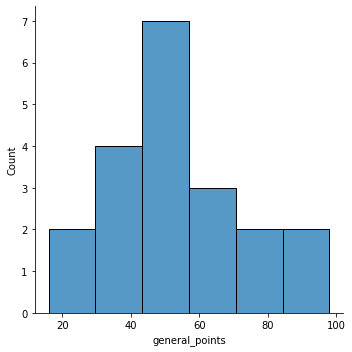

In [12]:
sns.displot(epl['general_points'])

The point distribution looks slightly right-skewed in the histogram.  
But, let's confirm it by plotting the Q-Q plot.

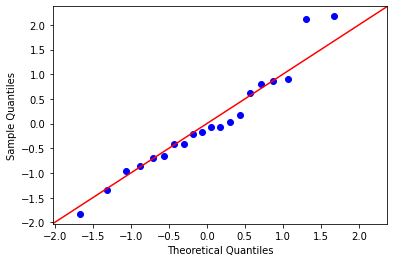

In [13]:
ax = sm.qqplot(epl['general_points'], fit=True, line='45')

The two strayed data points at the top indicates that the distribution is indeed slightly skewed to the right.  
Now, let's check if there's any outlier.

<AxesSubplot:>

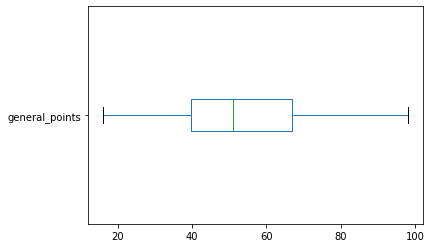

In [14]:
epl['general_points'].plot.box(vert=False)

There seems to be no outlier in the team point data based on the box plot.  
But, seeing how the top 2 teams performs, Manchester City and Liverpool, are far up ahead than the rest.

Next, let's see who's the best attacker in EPL.  
First, we need to compute a new variable that reflects on shots accuracy.

In [15]:
# compute a new variable that reflects on shots accuracy
epl['attack_shots_accuracy'] = epl['attack_shots_on_target'].div(epl['attack_shots'], axis=0)

Then, we're going to select some variables that affect the team's offense and give them weights.

In [16]:
# select the attack variables that we're interested in and give them weights
atk = ['attack_scored', 'attack_shots_accuracy', 'attack_posession', 'attack_pass_accuracy']
atk_weight = [0.4, 0.3, 0.15, 0.15]

In [17]:
# for standardizing the variables
scaler = MinMaxScaler()

In [18]:
# copy the team names and scale the variables
epl_atk = epl[['Team']].copy()
epl_atk[atk] = scaler.fit_transform(epl[atk])

# compute the rating by averaging the scaled variables
epl_atk['attack_rating'] = epl_atk.mean(axis=1)

In [19]:
# the best offensive team is ...
top_atk = epl_atk.nlargest(5, 'attack_rating')[['Team', 'attack_rating']]
top_atk

,Team,attack_rating
0,Manchester City,0.913863
1,Liverpool,0.817920
5,Manchester United,0.723097
4,Arsenal,0.671973
2,Chelsea,0.649497


<AxesSubplot:xlabel='attack_rating', ylabel='Team'>

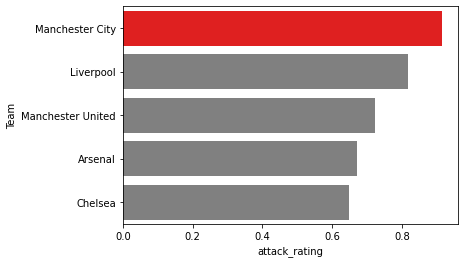

In [20]:
attack_rating = top_atk['attack_rating']
sns.barplot(x='attack_rating', y='Team', data=top_atk, orient='h', palette=["grey" if x != max(attack_rating) else 'red' for x in attack_rating])

No surprises here that the champion has the best attack in the league.  
  
Now, we'll be looking for the defensive side.  
It'll be a little different because the defensive stats tend to be inflated in favor of the weaker teams.  
We'll only be using the goals conceded stats to determine the defensive team.

In [21]:
# select teams that conceded goals the least
top_def = epl.nsmallest(5, 'defence_goals_conceeded')[['Team', 'defence_goals_conceeded']]
top_def

,Team,defence_goals_conceeded
1,Liverpool,22
0,Manchester City,23
2,Chelsea,39
3,Tottenham,39
6,Wolverhampton,46


<AxesSubplot:xlabel='defence_goals_conceeded', ylabel='Team'>

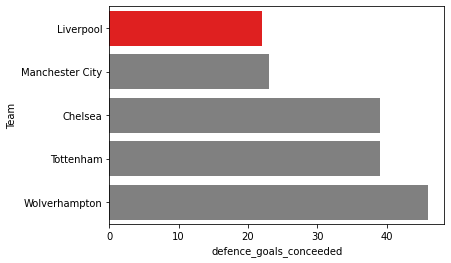

In [22]:
goals_conceded = top_def['defence_goals_conceeded']
sns.barplot(x='defence_goals_conceeded', y='Team', data=top_def, orient='h', palette=["grey" if x != min(goals_conceded) else 'red' for x in goals_conceded])

Liverpool edges out Manchester City in the defensive end.  
What's interesting is the difference between them and the rest.  
Manchester City and Liverpool were really neck and neck this season.

To see how the teams are doing financially, I'm going to use the TV revenue and their market value as variables.  
Since both variables have the same importance, so their weights are equal.

In [23]:
fin = ['finance_tv_revenue', 'finance_team_market']
epl_fin = epl[['Team']].copy()
epl_fin[fin] = scaler.fit_transform(epl[fin])

# add the scaled variables into the new dataframe
epl_fin['finance_rating'] = epl_atk.mean(axis=1)

top_fin = epl_fin.nlargest(5, 'finance_rating')[['Team', 'finance_rating']]
top_fin

,Team,finance_rating
0,Manchester City,0.913863
1,Liverpool,0.817920
5,Manchester United,0.723097
4,Arsenal,0.671973
2,Chelsea,0.649497


<AxesSubplot:xlabel='finance_rating', ylabel='Team'>

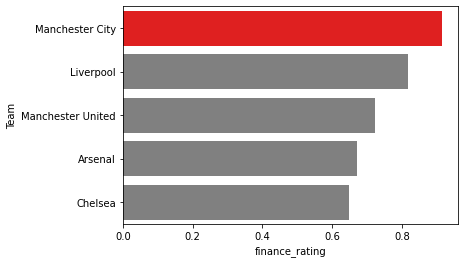

In [24]:
finance_rating = top_fin['finance_rating']
sns.barplot(x='finance_rating', y='Team', data=top_fin, orient='h', palette=["grey" if x != max(finance_rating) else 'red' for x in finance_rating])

Manchester City is doing really well right now.  
Liverpool, Manchester United, Arsenal, and Chelsea are not too far behind.

<AxesSubplot:xlabel='finance_rating', ylabel='general_points'>

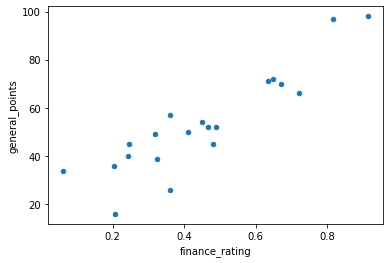

In [25]:
epl['finance_rating'] = epl_fin['finance_rating']
epl.plot.scatter(x='finance_rating', y='general_points')

Looks like money is still one of the most important aspect in a team's sucess.